In [1]:
#from mls import Learn
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd
import scipy.stats

import SDSS_CCL as sccl

import emcee
import corner
from chainconsumer import ChainConsumer

In [2]:
def log_prior(theta):
    b, Om = theta
    if 0.6 < b < 4 and 0.1 < Om < 1.0 :
        return 0.0
    return -np.inf

In [3]:
def log_likelihood(theta, corr_tree, data, centers):
    corr_ccl = sccl.getcorrCCL(theta, data, centers)
    return -0.5*np.einsum('i,i',(corr_tree- theta[0]**2*corr_ccl), 
                          np.einsum('ij,j', inv_cov,(corr_tree- theta[0]**2*corr_ccl)))

In [4]:
def log_probability(theta, corr_tree, data, centers):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, corr_tree, data, centers)

In [ ]:
"""
The following functions are defined in SDSS_CCL.py or SDSS_TREECORR.py:

# Calls getcorrTree2 to create centers
def findb2(data, minsep, maxsep):
    corr, centers, cov = getcorrTree2(data, minsep, maxsep)
    corr_camb = getcorrCCL([1, 0.31], data, centers)
    
    corr_tree = corr[0]
    
    inv_cov = np.linalg.inv(cov)
    
    result = minimize(biasfunc2, np.array([0.1,0.1]), args = (corr_tree, data, centers, inv_cov), bounds = ((0.6,4),(0,1)));
    
    return result

def getcorrCCL(theta, data, centers):
    
    Nz, be = np.histogram(data['z'], bins=8, range=(0.05,0.15))
    z = 0.5*(be[1:] + be[:-1])
   
    h=0.675 # Planck value for h (Hubble parameter)
    Ob = 0.044 # Planck value for Omega_b (Baryon energy density)
    Om = theta[1] # Planck value for Omega_m (Matter energy density)
    Oc = Om-Ob # Value for Omega_c (Cold dark matter energy density)
    ns=0.965 # Scalar index
    
    cosmo = ccl.Cosmology(Omega_c=Oc, Omega_b=Ob, h=h, sigma8=0.8, n_s=ns, matter_power_spectrum='linear')
    
    tracer = ccl.NumberCountsTracer(cosmo,has_rsd=False,
                                                dndz=(z,Nz),
                                                bias=(z,np.ones_like(z)))

    ell = np.arange(1, 7500) # is this the same as lmax?
    angular_power_spectrum = ccl.angular_cl(cosmo, tracer, tracer, ell)
    
    th = centers #np.linspace(0,0.2, num = 15)

    ang_corr_func = ccl.correlation(cosmo, ell, angular_power_spectrum, th)
    
    return ang_corr_func

def getcorrTree2(data, minsep, maxsep):
    corr, bincenters, cov = stc2.calccorr(data, minsep, maxsep)
    return [corr, math.e**bincenters, cov]

# from treecorr, aka stc2
def calccorr(dataset, minsep = 1/60, maxsep = 6):
    
    nn = treecorr.NNCorrelation(nbins = 16, min_sep = minsep, max_sep = maxsep, sep_units = 'deg',var_method='jackknife') 
    cat = treecorr.Catalog(ra = dataset['ra'], dec = dataset['dec'], ra_units='deg', dec_units='deg',npatch = 100)
    nn.process(cat)

    catrand = randomcorr(dataset, cat, minsep, maxsep)
    rr = treecorr.NNCorrelation(nbins = 16, min_sep = minsep, max_sep = maxsep, sep_units = 'deg',var_method='jackknife')
    rr.process(catrand)
    
    dr = treecorr.NNCorrelation(nbins = 16, min_sep = minsep, max_sep = maxsep,sep_units = 'deg',var_method='jackknife')
    dr.process(cat, catrand)

    corr = nn.calculateXi(rr, dr)
    bin_centers = nn.meanlogr
    cov = nn.estimate_cov('jackknife')
    
    return [corr, bin_centers, cov]

"""

In [5]:
data = sccl.getdata()[0]

In [6]:
# see file SDSS_CCL.ipynb
sccl.findb2(data,1/60, 6)

      fun: 1363.7102625924726
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 2.04636308e-03, -2.58767432e+02])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 234
      nit: 25
   status: 0
  success: True
        x: array([1.69299575, 0.53596562])

In [8]:
sccl.findb2(data,1/40, 4)

      fun: 576.821158676583
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-193.1038355, -250.4461122])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 54
      nit: 3
   status: 0
  success: True
        x: array([1.17736337, 0.99999999])

In [9]:
sccl.findb2(data,1/2, 4)

      fun: 21.794607783834536
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-15.56187428, 199.86005881])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 78
      nit: 4
   status: 0
  success: True
        x: array([1.37709034, 0.27170859])

In [10]:
sccl.findb2(data,1, 10)

CAMBError: Error in Fortran called from calc_transfer:
ThemoData Init: failed to find end of recombination

In [11]:
data = sccl.getdata()[0]
corr_tree, centers, cov = sccl.getcorrTree2(data, 1/2, 4)
corr_tree = corr_tree[0]
inv_cov = np.linalg.inv(cov)

In [12]:
#pos = [1.2153125000000014, 0.31] + 1e-4 * np.random.randn(6, 2)
pos = [1.37709034, 0.27170859] + 1e-4 * np.random.randn(6, 2)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args = (corr_tree, data, centers))

In [13]:
sampler.run_mcmc(pos, 100, progress=True);

100%|██████████| 100/100 [17:21<00:00, 10.42s/it]


In [14]:
flat_samples = sampler.get_chain(flat=True)
print(flat_samples.shape)

(600, 2)


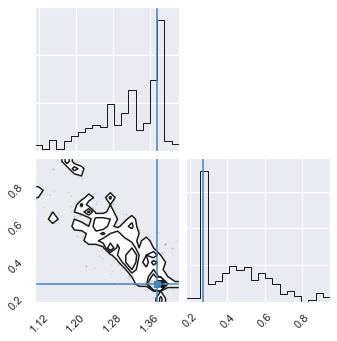

In [15]:
fig = corner.corner(
    flat_samples, truths=[1.37709034, 0.27170859]
);

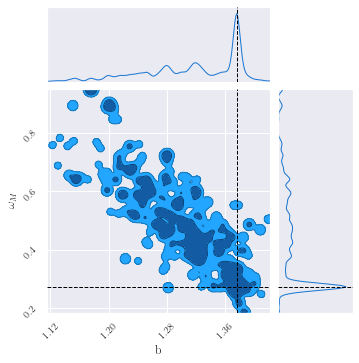

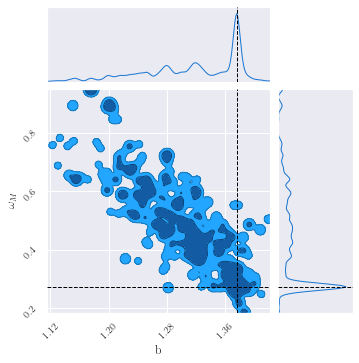

In [16]:
c = ChainConsumer()
c.add_chain(flat_samples, parameters=["b", "$\omega_M$"])
c.plotter.plot(filename="mcmc1.png", figsize="column", truth=[1.37709034, 0.27170859])

In [17]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], (['b','\Omega_M'])[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [19]:
theta1 = [1.37709034, 0.27170859]
theta2 = [1.2153125000000014, 0.31]

corr_ccl1 = sccl.getcorrCCL(theta1, data, centers)
result1 = np.einsum('i,i',(corr_tree- theta1[0]**2*corr_ccl1), 
                    np.einsum('ij,j', inv_cov,(corr_tree- theta1[0]**2*corr_ccl1)))

corr_ccl2 = sccl.getcorrCCL(theta2, data, centers)
result2 = np.einsum('i,i',(corr_tree- theta2[0]**2*corr_ccl2), 
                    np.einsum('ij,j', inv_cov,(corr_tree- theta2[0]**2*corr_ccl2)))

In [21]:
result1

40.23281963084836

In [22]:
result2

49.035209988234996

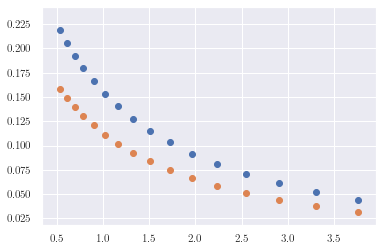

In [23]:
plt.scatter(centers, theta1[0]*corr_ccl1)
plt.scatter(centers, corr_ccl1)

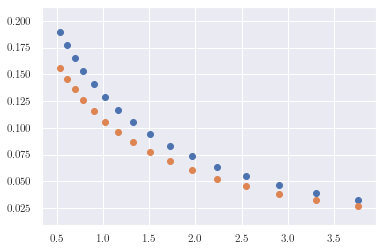

In [24]:
plt.scatter(centers, theta2[0]*corr_ccl2)
plt.scatter(centers, corr_ccl2)

In [ ]:
"""
Aaaaand again, just by editing the data. Maybe.

"""

data = sccl.getdata()[0]
corr_tree, centers, cov = sccl.getcorrTree2(data)
corr_tree = corr_tree[0]
inv_cov = np.linalg.inv(cov)


In [ ]:
res1 = findb2(data)

In [ ]:
pos = [1.37709034, 0.27170859] + 1e-4 * np.random.randn(6, 2)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args = (corr_tree, data, centers))
sampler.run_mcmc(pos, 100, progress=True);

In [ ]:
c = ChainConsumer()
c.add_chain(flat_samples, parameters=["b", "$\omega_M$"])
c.plotter.plot(filename="mcmc1.png", figsize="column", truth=[1.37709034, 0.27170859])